# Firefox engineering bug-to-nightly lead time trends

Has the time from a bug being filed until all changesets addressing that bug have been fixed changed significantly from 2016 to 2018?

In [1]:
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")

We'll use a 3 month block, January to March in 2016, 2017, and 2018.  This should eliminate any large month-to-month effects.  The data should also be consistant because no major team event happens during these months.

In [2]:
files = ['data/nightly-{}{}.parq'.format(y, m)
         for y in (2016, 2017, 2018) 
         for m in ('01', '02', '03')]

In [3]:
df = pd.concat([pd.read_parquet(fn) for fn in files], ignore_index=True)
df.shape

(40092, 8)

Fix the timezone locale

In [4]:
df['bug_creation_time'] = df['bug_creation_time'].dt.tz_localize('UTC')

For our "time from changeset inception until changeset fix" calculation we will take the time from when a changeset was created until the time that changeset was availalbe for download as a nightly build.

In [5]:
df['duration'] = df['nightly_publish_time'] - df['bug_creation_time']
df['duration'].min()

Timedelta('-640 days +19:15:17')

Clean up bad negative timedeltas.

In [6]:
# Scrub negative bug creation times
df = df.drop(df[df['duration'].dt.days < 0].index)
df['duration'].min()

Timedelta('0 days 02:04:33')

In [7]:
grouped = df.groupby(df['nightly_publish_time'].dt.year)

In [8]:
print("Number of unique builds per year")
grouped['nightly_build_id'].nunique()

Number of unique builds per year


nightly_publish_time
2016     85
2017     88
2018    167
Name: nightly_build_id, dtype: int64

In [9]:
grouped['duration'].describe()

,count,mean,std,min,25%,50%,75%,max
nightly_publish_time,,,,,,,,
2016,11793,269 days 02:33:50.001865,976 days 01:03:51.380716,0 days 06:39:46,4 days 08:44:29,14 days 10:48:00,77 days 12:36:22,6162 days 07:45:10
2017,16166,1320 days 23:30:53.659841,2470 days 11:53:52.703041,0 days 03:24:37,6 days 04:12:13.250000,27 days 03:24:11,405 days 22:59:37.500000,7067 days 22:14:58
2018,12132,374 days 05:54:18.406116,1306 days 18:03:09.246195,0 days 02:04:33,3 days 05:19:08,12 days 19:18:13,66 days 02:14:15,6694 days 13:57:22


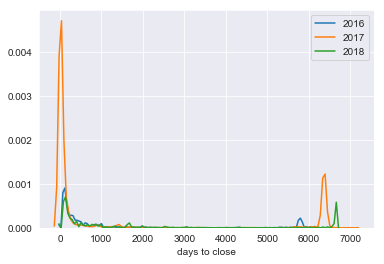

In [10]:
for year, data in grouped['duration']:
    ax = sns.kdeplot(data.dt.days, label=year)
    ax.set(xlabel="days to close")

## Bugs filed within 90 days

Focus on bugs filed within 90 days of the code landing that addresses them.  That range describes the majority of code landings.

In [11]:
last90 = df[df['duration'].dt.days <= 90]

In [12]:
grouped = last90['duration'].groupby(last90['nightly_publish_time'].dt.year)
grouped.describe()

,count,mean,std,min,25%,50%,75%,max
nightly_publish_time,,,,,,,,
2016,9076,17 days 06:31:48.324041,20 days 12:33:31.817496,0 days 06:39:46,3 days 07:01:45.500000,8 days 01:58:01,22 days 14:51:47,90 days 22:51:20
2017,10530,18 days 16:53:33.519563,21 days 12:10:14.586857,0 days 03:24:37,3 days 12:13:50,8 days 18:10:35,25 days 16:42:08,90 days 23:30:48
2018,9541,16 days 10:11:46.821402,20 days 18:30:42.771489,0 days 02:04:33,2 days 05:43:22,6 days 19:57:29,22 days 12:06:12,90 days 23:59:09


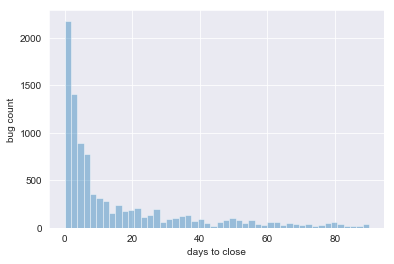

In [13]:
ax = sns.distplot(grouped.get_group(2018).dt.days, kde=False)
ax.set(xlabel="days to close", ylabel="bug count");

Let's see how this looks fit to a KDE plot.

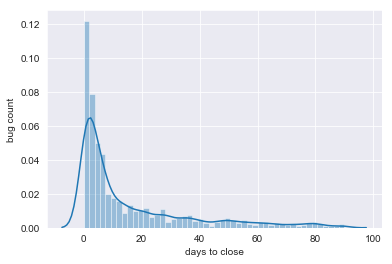

In [14]:
ax = sns.distplot(grouped.get_group(2018).dt.days)
ax.set(xlabel="days to close", ylabel="bug count");

Now we can compare the result with other years.

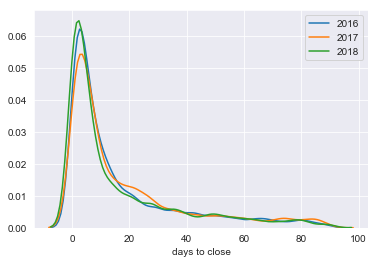

In [15]:
for year, data in grouped:
    ax = sns.kdeplot(data.dt.days, label=year)
    ax.set(xlabel="days to close")

A cumulative distribution shows us the difference in bug fix times between years as "percent of bug fix durations that fall below a given probability".

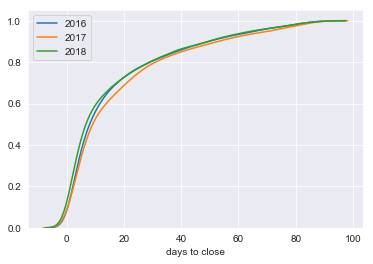

In [16]:
for year, data in grouped:
    ax = sns.kdeplot(data.dt.days, label=year, cumulative=True)
    ax.set(xlabel="days to close")